Python version of sparse autoencoder exersise. 
I was initially using only tensorflow, but Keras has a nice api for l
In Tensorflow, if you want to access weights, you have to create your own class of your model and define a method to load/restore weights, which is somewhat cumbersome if your goal is a rapid prototyping. Keras is really good in prototyping.  

This is what I wanted !!!! : https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
> If TensorFlow is your primary framework, and you are looking for a simple & high-level model definition interface to make your life easier, this tutorial is for you.

**Warning**:
You shouldn't call tf.reset_default_graph() by yourself. Keras takes care of it with clear_session() in [here](https://github.com/fchollet/keras/blob/master/keras/backend/tensorflow_backend.py), and if you call tf.reset_default_graph() by yourself, tensorflow creates another default graph, which will destroy the bundle between keras session's graph.  

## Step 1: Generate training set 

In [1]:
import scipy.io
mat = scipy.io.loadmat("./SparseAutoencoder/starter/IMAGES.mat")
IMAGES = mat["IMAGES"]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Here are some sample images that we are going to work on. The images have been preprosessed using whitening. 

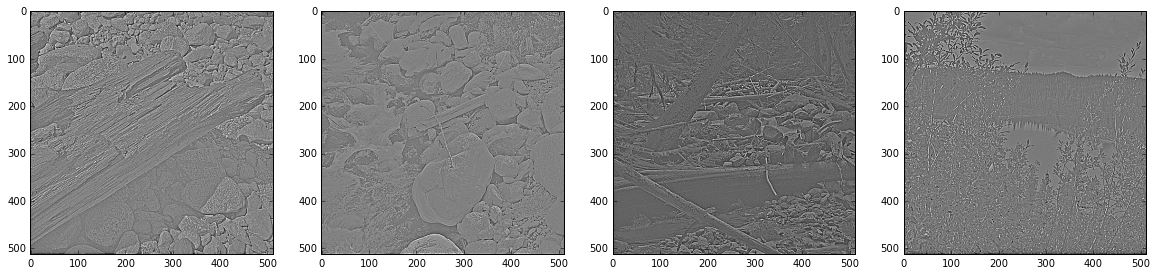

In [3]:
% matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(20,5))
for i in range(4):
    ax[i].imshow(IMAGES[:,:,i], cmap="gray")

In [4]:
def sampleIMAGES():
    patchsize = 8
    numpatches = 10000
    patches = np.zeros([patchsize*patchsize, numpatches])
    image_size, image_size, num_images = IMAGES.shape
    for i in range(numpatches):
        rand_id = np.random.randint(num_images)
        rand_pt = np.random.randint(image_size-patchsize)
        patch = IMAGES[rand_pt:rand_pt+patchsize, rand_pt:rand_pt+patchsize, rand_id]
        patches[:, i] = patch.reshape(patchsize*patchsize)
    
    patches = normalizeData(patches)
    return patches

The mean and standard deviation is not standardized, so we will fix it. 

In [41]:
patches.shape
print(np.mean(patches))
print(np.std(patches))

-0.00233650638244
0.278929314191


In [5]:
def normalizeData(patches):
    # subtract its mean and truncate it  to -/+3*std
    patches = patches - np.mean(patches)
    pstd = np.std(patches)
    patches = np.clip(patches, -pstd, pstd) / pstd
    
    # rescale from [-1, 1] to [0.1, 0.9] 
    patches = (patches + 1) * 0.4 + 0.1
    return patches

In [6]:
patches = sampleIMAGES()

In [7]:
print(np.mean(patches))
print(np.min(patches))
print(np.max(patches))

0.491667484749
0.1
0.9


Now it's correctly normalized. 

## Step 2: Sparse autoencoder objective

The loss function for sparse autoencoder should be 
$$ 
J_{sparse}(W,b)  = J(W,b) + \sum_i^{h} \rho \log \frac{\rho}{\hat{\rho_i}} + (1 - \rho) \log \frac{1 - \rho}{1 - \hat{\rho_i}}
$$

In [ ]:
nCk p^k (1-p)^(n-k)

In [32]:
binomial(20, 0.5) 

0.176197052002


In [31]:
def binomial(n, p):
    from scipy.special import comb
    k = 10
    ans = comb(n, k) * pow(p, k) * pow(1-p, n-k)
    print(ans)

We will use Keras and Tensorflow to define sparse autoencoder model. 

In [8]:
from keras.models import Sequential
from keras import backend as K
#K.clear_session() K.set_session(sess)
#sess = K.get_session()
#K.set_session(sess) 
import tensorflow as tf

Using TensorFlow backend.


In [12]:
K.get_session().graph 

In [14]:
tf.get_default_graph() 

In [84]:
class AE():
    def __init__(self, input_size):
        self.model = Sequential()
        from keras.layers import Dense, Activation
        input_size = 64
        self.model.add(Dense(output_dim=25, input_dim=input_size))
        self.model.add(Activation("sigmoid"))
        self.model.add(Dense(output_dim=64, input_dim=25))
        self.model.add(Activation("sigmoid")) 

        self.input = tf.placeholder(tf.float32, shape=[None, input_size])
        self.output = self.model(self.input)
        
        self.loss = tf.reduce_sum(tf.square(self.input - self.output)) / input_size
        #self.train_op = tf.train.GradientDescentOptimizer(0.001).minimize(self.loss)
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(self.loss)
        
        self.sess = tf.Session()
        from keras import backend as K
        K.set_session(self.sess)
        self.sess.run(tf.initialize_all_variables())
        
    def getWeights(self):
        lists = self.model.trainable_weights
        return [self.sess.run(lists[i]) for i in range(len(lists))]
    
    def fit(self, x):
        _, cost = self.sess.run([self.train_op, self.loss], feed_dict={self.input:x})
        return cost

In [7]:
X_train = np.transpose(patches) 
Y_train = np.transpose(patches) 

In [89]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

def get_batch(data, batch_size, current_index):
    return data[current_index:(current_index+batch_size)], current_index + batch_size

with tf.Graph().as_default():
    ae = AE(64)
    max_epoch = 10
    batch_size = 128
    total_batch = 10000 // batch_size 
    cost_list = []
    for epoch in range(max_epoch):
        costs = 0
        current_pos = 0
        for i in range(total_batch):
            #minibatch = get_random_block_from_data(X_train, batch_size)
            minibatch, current_pos = get_batch(X_train, batch_size, current_pos)
            cost = ae.fit(minibatch)
            cost = cost / batch_size
            #print(cost)
            costs += cost
        print(costs/total_batch)
        cost_list.append(costs/total_batch)
        

/usr/local/lib/python3.4/site-packages/keras/backend/tensorflow_backend.py:114: UserWarning: The default TensorFlow graph is not the graph associated with the TensorFlow session currently registered with Keras, and as such Keras was not able to automatically initialize a variable. You should consider registering the proper session with Keras via `K.set_session(sess)`.
  warnings.warn('The default TensorFlow graph is not the graph '


0.0621893524837
0.0590619749079
0.0560509520941
0.052236559968
0.048194903546
0.0444041830607
0.0410382111485
0.0381081902828
0.035549592967
0.0332834954159


In [52]:
weight_list = ae.getWeights()
tf.InteractiveSession()
weight_list[0].shape

(64, 25)